This tutorial will walk you through how to perform basic supervised machine learning (ML) tasks on different types of data that might be relevent for various scientific applications. First we must generate some representative data.

# Generating Data

In [19]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('aeroacoustic_data.csv', index_col=0)
df

,Wind Speed (m/s),Turbulence Intensity,Air Temperature (deg. C),Relative Humidity (%),Air Pressure (kPa),Ground Factor,Mean SPL (dBA),Min SPL (dBA),Max SPL (dBA),Std SPL (dBA)
0,10.793897,0.231201,-1.633835,72.372167,85.101743,0.449763,39.715627,14.489870,66.211880,11.490407
1,9.481999,0.192914,31.703903,88.838286,86.756918,0.296707,35.873743,3.975388,62.796766,12.497429
2,5.693081,0.246257,-2.418207,66.732174,81.204674,0.437873,24.420716,0.000000,51.461427,11.975378
3,10.342401,0.204216,0.842532,73.749144,94.550065,0.265575,39.779339,12.623927,66.152278,11.656338
4,6.545629,0.370817,-8.804310,80.973740,93.346108,0.340786,32.869723,4.959554,60.291112,12.085621
...,...,...,...,...,...,...,...,...,...,...
14946,5.719991,0.138004,34.657657,20.999314,87.533279,0.105367,21.061857,0.000000,47.338883,11.836189
14947,24.158779,0.182486,18.169352,71.961303,91.943795,0.382619,46.782087,28.280414,71.772722,11.006239
14948,10.909666,0.368894,18.190962,72.054923,97.161724,0.173619,45.470961,21.629900,72.409466,11.412038
14949,20.671765,0.162101,22.980963,60.831737,93.388443,0.412476,43.716430,24.937355,68.487435,11.073088


In [9]:
input_names = [col for col in df.columns[:6]]
output_names = ['Max SPL (dBA)']
print("Input parameters:", input_names)

Input parameters: ['Wind Speed (m/s)', 'Turbulence Intensity', 'Air Temperature (deg. C)', 'Relative Humidity (%)', 'Air Pressure (kPa)', 'Ground Factor']


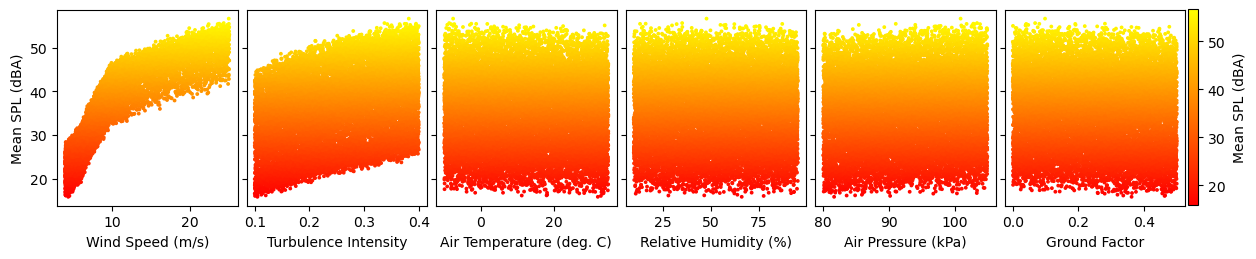

In [14]:
fig, ax = plt.subplots(1, 6, figsize=(12, 2.), sharey='row')
sm = plt.cm.ScalarMappable(cmap='autumn', norm=mpl.colors.Normalize(vmin=df[output_names].min(), vmax=df[output_names].max()))
for i, input in enumerate(input_names):
    ax[i].scatter(df[input], df[output_names], s=3, color=sm.to_rgba(df[output_names]))
    ax[i].set_xlabel(input)
ax[0].set_ylabel(output_names[0])
cax = plt.axes([0.78, 0.013, 0.25, 0.98])
cax.axis('off')
cbar = fig.colorbar(sm, ax=cax,)
# cbar.ax.tick_params(labelsize=11)
cbar.ax.set_ylabel(output_names[0], rotation=90, labelpad=5)
fig.subplots_adjust(left=0.05, right=0.99, wspace=0.05, bottom=0.01, top=0.99)

# Preprocessing the data
Most ML problems optimally operate on data that is normalized. The type optimal type of normalization depends upon the structure of the data and the desired output.

For this data we will use a rather standard that shifts and scales the data to a distribution centered around 0 with standard deviation equal to 1.

$$ x' = \frac{x - \mu(x)}{\sigma(x)}$$

It is often useful to also create an inverse normalization function which can be used to convert the ML model predictions back to the physical space.

In [17]:
x = df[input_names].to_numpy()  
scaler_x = preprocessing.StandardScaler().fit(x)
x_norm = scaler_x.transform(x)

y = df[output_names].to_numpy().reshape(-1, 1)
scaler_y = preprocessing.StandardScaler().fit(y)
y_norm = scaler_y.transform(y)

n_samples, n_feats = x_norm.shape
print(f"X.shape:{x_norm.shape}")
print(f"y.shape:{y_norm.shape}")


X.shape:(14951, 6)
y.shape:(14951, 1)


# Creating a ML Model
Now that the data is preprocessed nicely, let's create a standard feed-forward neural network and train it to learn the relationship between the features (x) and the output (y).

The initial model will be have an input layer, three hidden layer with 64 neurons, and an output layer. The number of hidden layers, neurons per layer, and a variety of other so-called "hyperparameters" will have a noticable impact on model results. These values require extensive tuning depending on the problem at hand.

In [18]:
# Import PyTorch and related modules
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchinfo import summary

# Create a class for the PyTorch model
class ANN(nn.Module):
    def __init__(self, num_feat, width, **kwargs):
        super(ANN, self).__init__(**kwargs)

        self.num_feat = num_feat
        self.width = width
        
        # One Dense layer connecting inputs to bulk layers
        self.dense_layer_in = nn.Linear(self.num_feat, self.width)
        # Bulk layers
        self.bulk1 = nn.Linear(self.width, self.width)
        self.bulk2 = nn.Linear(self.width, self.width)
        # Output layer with one feature
        self.output_layer = nn.Linear(self.width, 1)
        

    def forward(self, inputs):
        x = inputs

        x = self.dense_layer_in(x)
        x = F.relu(x)

        x = self.bulk1(x)
        x = F.relu(x)
        x = self.bulk2(x)
        x = F.relu(x)

        x = self.output_layer(x)
        return x


model = ANN(num_feat=n_feats, width=64)
print(summary(model, input_size=(1, n_feats)))

# Define the loss function and optimizer for training
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   448
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 64]                   4,160
├─Linear: 1-4                            [1, 1]                    65
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04


In [21]:
# Ensure numpy arrays are in float32, not float64
x_norm = np.float32(x_norm)
y_norm = np.float32(y_norm)

# Generate train and test datasets with 8-20 split
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.20, random_state=42)
# Further split the test set into a validation set (final split is 80-10-10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# precompute the unnormalized versions of y
y_train_real = scaler_y.inverse_transform(y_train)
y_val_real = scaler_y.inverse_transform(y_val)
y_test_real = scaler_y.inverse_transform(y_test)

In [22]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
num_epochs = 100

# Create the data holder for training/validation (the test set should be held separate from any model training)
dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
dataset_val = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [23]:
# Make a history dict for storing metrics
history = {"loss": [], "val_loss": []}
model = ANN(num_feat=n_feats, width=64)
# print(summary(model, input_size=(1, n_feats)))

# Define the loss function and optimizer for training
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Now we can train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    val_loss = 0.0
    
    for idx, data in enumerate(dataloader):
        xin, y_truth = data

        optimizer.zero_grad()
        
        # forward pass and compute loss
        pred = model(xin)
        loss = criterion(pred, y_truth)

        # Zero out the gradients, perform a backward pass, and update weights
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()
    running_loss /= len(dataloader)

    # Compute the validation loss
    with torch.no_grad():
        for data_val in dataloader_val:
            xin_val, y_truth_val = data_val
            pred_val = model(xin_val)
            loss_val = criterion(pred_val, y_truth_val)
            val_loss += loss_val.item()
        val_loss /= len(dataloader_val)


    print(f"Epoch = {epoch+1}, loss = {running_loss}, val_loss = {val_loss}")
    history["loss"].append(running_loss)
    history["val_loss"].append(val_loss)

Epoch = 1, loss = 0.08555354374052489, val_loss = 0.007227598194112169
Epoch = 2, loss = 0.004116508889666953, val_loss = 0.0034150809663882915
Epoch = 3, loss = 0.002421366429811762, val_loss = 0.001959724028525438
Epoch = 4, loss = 0.0017722185029097918, val_loss = 0.0018434067927994469
Epoch = 5, loss = 0.001402093577391672, val_loss = 0.0014719344623525567
Epoch = 6, loss = 0.001133903574520961, val_loss = 0.0011220619805712014
Epoch = 7, loss = 0.0009062639780013877, val_loss = 0.0007789266404715624
Epoch = 8, loss = 0.0007186350403328671, val_loss = 0.0006592930975726786
Epoch = 9, loss = 0.0006161747697723984, val_loss = 0.0007115031599978659
Epoch = 10, loss = 0.0005662281864666987, val_loss = 0.0006574080276124655
Epoch = 11, loss = 0.0005385018215514097, val_loss = 0.0005891533652716812
Epoch = 12, loss = 0.0004886399552161945, val_loss = 0.0005586546643864997
Epoch = 13, loss = 0.00048402119241935015, val_loss = 0.0006308782705789471
Epoch = 14, loss = 0.00043978039130137706

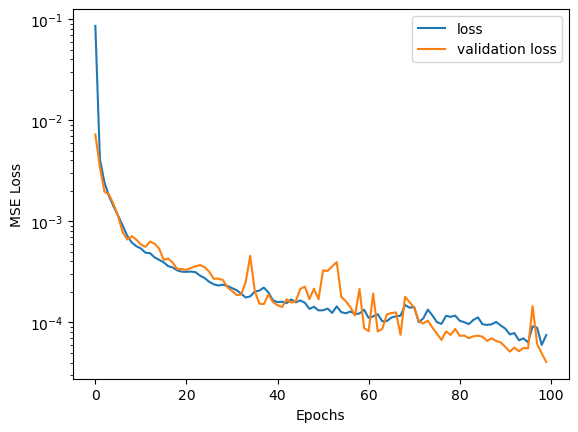

In [30]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.semilogy(history["loss"], label="loss")
ax.semilogy(history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [28]:
# Evaluate the model performance on train and validation data
pred_norm = model(torch.from_numpy(x_norm)).detach().numpy()
pred_norm_train = model(torch.from_numpy(x_train)).detach().numpy()
pred_norm_val = model(torch.from_numpy(x_val)).detach().numpy()
pred_norm_test = model(torch.from_numpy(x_test)).detach().numpy()
# Unscale the results and plot
pred_full = scaler_y.inverse_transform(pred_norm)
pred_train = scaler_y.inverse_transform(pred_norm_train)
pred_val = scaler_y.inverse_transform(pred_norm_val)
pred_test = scaler_y.inverse_transform(pred_norm_test)

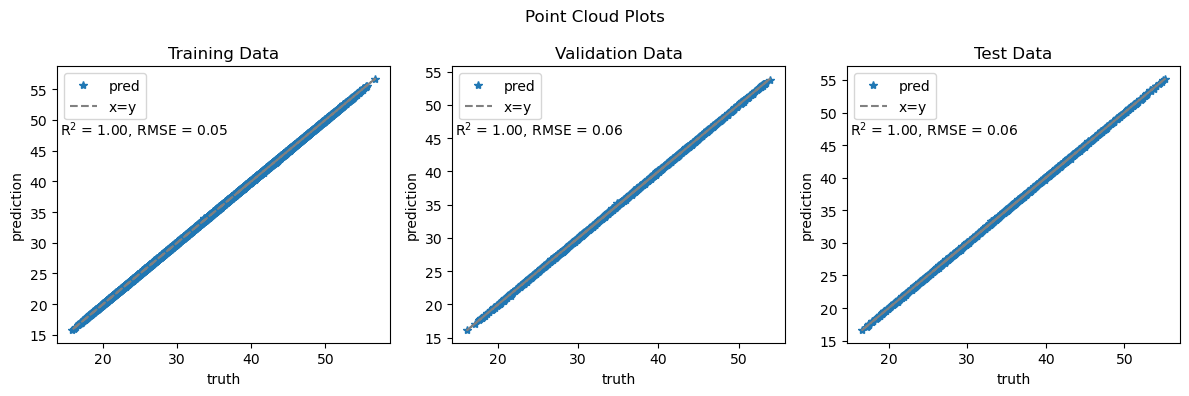

In [29]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error, r2_score
def pred_stats(pred, truth):
    r_sq = r2_score(truth, pred)
    rmse = np.sqrt(mean_squared_error(truth, pred))
    return r_sq, rmse
    
# Training data
r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# Validation plot
ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")
# Test plot
ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
ax3.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
ax3.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()